In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
from os.path import expanduser

In [10]:
EXPERIMENT_NAME = 'P3856_YHE010'

#### prepare the TFD/E results

In [11]:
# load the results
EXPERIMENT_DIR = '/media/data-4t-a/results-P3856_YHE010/2022-03-28-17-55-06'
RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
tfde_results_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [12]:
# convert the identifications from JSON to Python objects
tfde_results_df['identifications_d'] = tfde_results_df.apply(lambda row: json.loads(row.identifications), axis=1)

In [13]:
def classify_protein(protein):
    result = 'UNKNOWN'
    if 'HUMAN' in protein.upper():
        result = 'Human'
    elif 'YEAST' in protein.upper():
        result = 'Yeast'
    elif 'ECOLI' in protein.upper():
        result = 'E. coli'
    return result

In [14]:
# separate some key metrics into separate columns
tfde_results_df['id_perc_q_value'] = tfde_results_df.apply(lambda row: row.identifications_d['perc_q_value'], axis=1)
tfde_results_df['id_count_all_runs'] = tfde_results_df.apply(lambda row: len(row.identifications_d['run_names']), axis=1)
tfde_results_df['id_number_of_proteins'] = tfde_results_df.apply(lambda row: row.identifications_d['number_of_proteins'], axis=1)

In [15]:
tfde_results_df['id_protein'] = tfde_results_df.apply(lambda row: row.identifications_d['proteins'][0], axis=1)
tfde_results_df['id_species'] = tfde_results_df.apply(lambda row: classify_protein(row.id_protein), axis=1)

In [16]:
tfde_results_df.id_species.unique()

array(['Human', 'E. coli', 'Yeast'], dtype=object)

In [17]:
# remove the results that couldn't be extracted or were not classified as a target
tfde_results_df = tfde_results_df[tfde_results_df.extractions.notnull()].copy()

In [18]:
# convert from JSON to Python objects
tfde_results_df['extractions_l'] = tfde_results_df.apply(lambda row: json.loads(row.extractions), axis=1)

In [19]:
# separate some key metrics into separate columns
tfde_results_df['ext_count_all_runs'] = tfde_results_df.apply(lambda row: len(row.extractions_l), axis=1)

In [20]:
tfde_results_df.sample(n=3)

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_number_of_proteins,id_protein,id_species,extractions_l,ext_count_all_runs
1402,AWMWLASDFSDGDAK,2,"{""perc_q_value"": 1.7327119e-05, ""run_names"": [...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 1.7327119e-05, 'run_names': [...",0.000017,6,1,"sp|P0DJD1|RGPD2_HUMAN,sp|P49792|RBP2_HUMAN,sp|...",Human,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,10
18251,YVSPQDVTTMQTCNTK,2,"{""perc_q_value"": 0.00027294705, ""run_names"": [...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 0.00027294705, 'run_names': [...",0.000273,2,1,sp|Q9H0J9|PAR12_HUMAN,Human,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,10
10372,LWDMFDSWR,2,"{""perc_q_value"": 0.00013037526, ""run_names"": [...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 0.00013037526, 'run_names': [...",0.000130,7,1,sp|Q15269|PWP2_HUMAN,Human,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,10


#### how many peptides were identified as non-human?

In [24]:
len(tfde_results_df)

17958

In [23]:
len(tfde_results_df[(tfde_results_df.id_species != "Human")])

228

In [25]:
228/17958*100

1.2696291346475108

In [26]:
tfde_results_df[(tfde_results_df.id_species != "Human") & (tfde_results_df.ext_count_all_runs >= 8)]

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_number_of_proteins,id_protein,id_species,extractions_l,ext_count_all_runs
287,AELTACLQQQASAK,2,"{""perc_q_value"": 0.00054323223, ""run_names"": [...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 0.00054323223, 'run_names': [...",0.000543,1,1,sp|P63389|YHES_ECOLI,E. coli,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,10
431,AGHQTSAESWGTGR,2,"{""perc_q_value"": 0.0054926332, ""run_names"": [""...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 0.0054926332, 'run_names': ['...",0.005493,1,1,"sp|P49626|RL4B_YEAST,sp|P10664|RL4A_YEAST",Yeast,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,10
448,AGLMLFNALVGKPEFR,2,"{""perc_q_value"": 0.0059943697, ""run_names"": [""...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 0.0059943697, 'run_names': ['...",0.005994,2,1,sp|P64606|MLAE_ECOLI,E. coli,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,10
452,AGMVQGLLQEFSLSSQEGVALMCLAEALLR,3,"{""perc_q_value"": 0.0097787829, ""run_names"": [""...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 0.0097787829, 'run_names': ['...",0.009779,1,1,sp|P09546|PUTA_ECOLI,E. coli,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,10
484,AGTTAPPKPM[15.9949]TESELILLMDTNGIGTDATIAEHIDK,3,"{""perc_q_value"": 0.0069689499, ""run_names"": [""...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 0.0069689499, 'run_names': ['...",0.006969,1,1,sp|P13099|TOP3_YEAST,Yeast,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,9
...,...,...,...,...,...,...,...,...,...,...,...,...
17488,WGTGQLWLSDECLYYILNFVEQCVVQK,3,"{""perc_q_value"": 0.0086302739, ""run_names"": [""...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 0.0086302739, 'run_names': ['...",0.008630,1,1,sp|P46970|NMD5_YEAST,Yeast,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,10
17627,WYPENGWFCYEK,2,"{""perc_q_value"": 0.0069689499, ""run_names"": [""...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 0.0069689499, 'run_names': ['...",0.006969,1,1,sp|Q08961|RKM1_YEAST,Yeast,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,10
17662,YATASAIAATAVASLVLAR,2,"{""perc_q_value"": 1.7327119e-05, ""run_names"": [...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 1.7327119e-05, 'run_names': [...",0.000017,2,1,"sp|P49626|RL4B_YEAST,sp|P10664|RL4A_YEAST",Yeast,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,8
17663,YATASAIAATAVASLVLAR,3,"{""perc_q_value"": 3.8858594e-05, ""run_names"": [...","[{""run_name"": ""P3856_YHE010_10_Slot1-1_1_5102""...","{'perc_q_value': 3.8858594e-05, 'run_names': [...",0.000039,4,1,"sp|P49626|RL4B_YEAST,sp|P10664|RL4A_YEAST",Yeast,[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102'...,10


In [34]:
tfde_results_df.columns

Index(['sequence', 'charge', 'identifications', 'extractions',
       'identifications_d', 'id_perc_q_value', 'id_count_all_runs',
       'id_number_of_proteins', 'id_protein', 'id_species', 'extractions_l',
       'ext_count_all_runs'],
      dtype='object')

In [38]:
tfde_results_df.loc[1402].extractions_l

[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102',
  'prob_target': 0.999673672329887,
  'intensity': 1572,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_2_Slot1-1_1_5094',
  'prob_target': 0.9996779267478852,
  'intensity': 1787,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_4_Slot1-1_1_5096',
  'prob_target': 0.9974152515196145,
  'intensity': 464,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_6_Slot1-1_1_5098',
  'prob_target': 0.9993449123204428,
  'intensity': 1260,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_8_Slot1-1_1_5100',
  'prob_target': 0.9996798453821888,
  'intensity': 1452,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_1_Slot1-1_1_5093',
  'prob_target': 0.998031041800031,
  'intensity': 724,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_3_Slot1-1_1_5095',
  'prob_target': 0.9995889065313796,
  'intensity': 1459,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_5_Slot1-1_1_5097',
  'prob_target': 0.9995705099787414,
  'intensity': 1130,
  'inferred': 0},
 {'run_name': 'P385

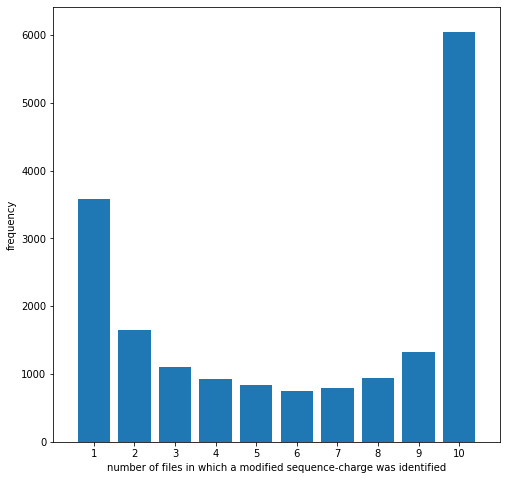

In [27]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)
plt.margins(0.06)

counts = np.bincount(tfde_results_df.id_count_all_runs)
number_of_runs_in_subset = 10

ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
# plt.ylim((0,18000))

plt.show()

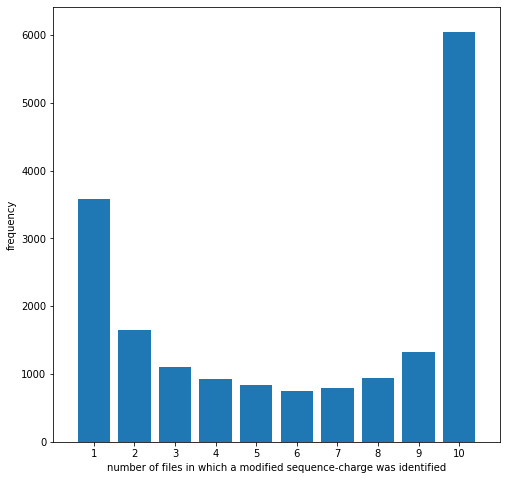

In [27]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)
plt.margins(0.06)

counts = np.bincount(tfde_results_df.id_count_all_runs)
number_of_runs_in_subset = 10

ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
# plt.ylim((0,18000))

plt.show()

In [28]:
tfde_nonhuman_results_df = tfde_results_df[(tfde_results_df.id_species != "Human")]

In [41]:
tfde_nonhuman_results_df.iloc[30].extractions_l

[{'run_name': 'P3856_YHE010_10_Slot1-1_1_5102',
  'prob_target': 0.9511636495097674,
  'intensity': 294,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_2_Slot1-1_1_5094',
  'prob_target': 0.995585069247857,
  'intensity': 237,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_4_Slot1-1_1_5096',
  'prob_target': 0.5915802023171703,
  'intensity': 170,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_6_Slot1-1_1_5098',
  'prob_target': 0.8433283547885855,
  'intensity': 291,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_8_Slot1-1_1_5100',
  'prob_target': 0.9761985876399175,
  'intensity': 212,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_3_Slot1-1_1_5095',
  'prob_target': 0.9447660198235226,
  'intensity': 245,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_5_Slot1-1_1_5097',
  'prob_target': 0.8867036844706305,
  'intensity': 179,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_7_Slot1-1_1_5099',
  'prob_target': 0.9925705994306396,
  'intensity': 249,
  'inferred': 0},
 {'run_name': 'P3856_YHE

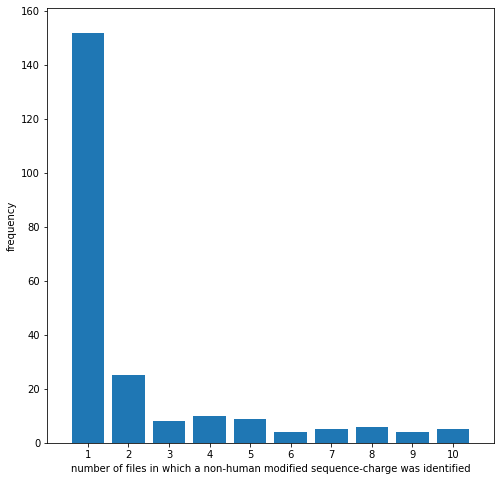

In [30]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)
plt.margins(0.06)

counts = np.bincount(tfde_nonhuman_results_df.id_count_all_runs)
number_of_runs_in_subset = 10

ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a non-human modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
# plt.ylim((0,18000))

plt.show()

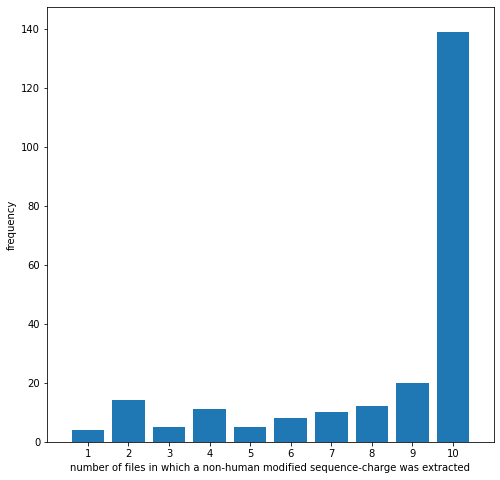

In [31]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)
plt.margins(0.06)

counts = np.bincount(tfde_nonhuman_results_df.ext_count_all_runs)
number_of_runs_in_subset = 10

ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a non-human modified sequence-charge was extracted')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
# plt.ylim((0,18000))

plt.show()